<a href="https://colab.research.google.com/github/MSLEE-AERO/FAI/blob/minsul/CNN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN using tensorflow.


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pathlib
import tensorflow.python.ops.numpy_ops.np_config as np_config

In [3]:
np_config.enable_numpy_behavior()

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [9]:
plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

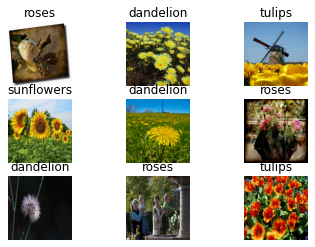

In [10]:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [15]:
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
num_classes = 5

In [17]:
class CustomConv(tf.keras.layers.Layer):
    def __init__(self,
                 filter_size,
                 prev_a_channel,
                 num_of_filters,
                 activation,
                 pad_size,
                 filter_stride):
        super().__init__()

        self.filter_w = tf.Variable(
            initial_value=tf.zeros(shape=(filter_size, filter_size, prev_a_channel, num_of_filters)),
            trainable=True
        )
        self.filter_b = tf.Variable(
            initial_value=tf.zeros(shape=(1, 1, 1, num_of_filters)),
            trainable=True
        )
        self.activation = tf.keras.activations.get(activation)
        self.pad_size = pad_size
        self.filter_stride = filter_stride
        self.filter_size = filter_size
        self.prev_a_channel = prev_a_channel
        self.num_of_filters = num_of_filters

    def call(self, prev_a, *args, **kwargs):
        # prev_a : (m * prev_a_height * prev_a_width * prev_a_channel)

        (m, prev_a_height, prev_a_width, prev_a_channel) = prev_a.shape
        #(filter_size, filter_size, prev_a_channel, num_of_filters) = self.filter_w.shape

        # batch size, height, width, channel

        paddings = tf.constant([[0, 0],
                                [self.pad_size, self.pad_size],
                                [self.pad_size, self.pad_size],
                                [0, 0]])

        prev_a_pad = tf.pad(
            tensor=prev_a,
            paddings=paddings
        )

        z_height = int((prev_a_height + 2 * self.pad_size - self.filter_size) / self.filter_stride) + 1
        z_width = int((prev_a_width + 2 * self.pad_size - self.filter_size) / self.filter_stride) + 1

        z = tf.Variable(
            initial_value=np.zeros(
                (m, z_height, z_width, self.num_of_filters),
                dtype='float32'),
            trainable=False
        )

        for i in range(m):
            for h in range(z_height):
                for w in range(self.num_of_filters):
                    for c in range(self.num_of_filters):
                        if i * h * w * c == 1:
                            print(m*z_height*self.num_of_filters*self.num_of_filters)
                        print(i, h, w, c)
                        #print(m, z_height, num_of_filters, num_of_filters)
                        height_start = h * self.filter_size
                        height_end = height_start + self.filter_size
                        width_start = w * self.filter_stride
                        width_end = width_start + self.filter_size

                        prev_a_slice = prev_a_pad[i, height_start:height_end, width_start:width_end, :]
                        #print('before reduce sum')
                        element = tf.math.reduce_sum(
                            prev_a_slice * self.filter_w[:, :, :, c] + self.filter_b[:, :, :, c]
                        )
                        #print('after reduce sum')

                        z[i, h, w, c].assign(element)
        return self.activation(z)

In [18]:
class CustomPool(tf.keras.layers.Layer):
    def __init__(self,
                 pool_size,
                 pool_stride,
                 mode='max'):
        super().__init__()
        self.mode = mode
        self.pool_size = pool_size
        self.pool_stride = pool_stride

    def call(self, a, *args, **kwargs):
        (m, a_height, a_width, a_channel) = a.shape

        pool_a_height = int((a_height - self.pool_size) / self.pool_stride) + 1
        pool_a_width = int((a_width - self.pool_size) / self.pool_stride) + 1
        pool_a_channel = a_channel

        pool_a = tf.Variable(np.zeros((m, pool_a_height, pool_a_width, pool_a_channel), dtype='float32'))

        for i in range(m):
            for h in range(pool_a_height):
                for w in range(pool_a_width):
                    for c in range(pool_a_channel):
                        height_start = h * self.pool_stride
                        height_end = height_start + self.pool_size
                        width_start = w * self.pool_stride
                        width_end = width_start + self.pool_size

                        a_slice = a[i, height_start:height_end, width_start:width_end, c]
                        if self.mode == 'max':
                            pool_a[i, h, w, c].assign(tf.math.reduce_max(a_slice))
                        elif self.mode == 'average':
                            pool_a[i, h, w, c].assign(tf.math.reduce_mean(a_slice))

                        else:
                            print('Invalid pooling mode choose max or average mode')
        return pool_a

In [19]:
class CustomCnnModel(tf.keras.models.Model):
    def __init__(self):
        super().__init__()

        self.conv1_layer = CustomConv(
            filter_size=3,
            prev_a_channel=3,
            num_of_filters=8,
            activation='relu',
            pad_size=1,
            filter_stride=1
        )
        # 2 * 2 is usual
        self.pool1_layer = CustomPool(
            pool_size=3,
            pool_stride=1,
            mode='max'
        )
        self.conv2_layer = CustomConv(
            filter_size=3,
            prev_a_channel=8,
            num_of_filters=16,
            activation='relu',
            pad_size=1,
            filter_stride=1
        )

        self.pool2_layer = CustomPool(
            pool_size=3,
            pool_stride=1,
            mode='max'
        )
        self.conv3_layer = CustomConv(
            filter_size=3,
            prev_a_channel=16,
            num_of_filters=32,
            activation='relu',
            pad_size=1,
            filter_stride=1
        )

        self.pool3_layer = CustomPool(
            pool_size=3,
            pool_stride=1,
            mode='max'
        )
        self.conv4_layer = CustomConv(
            filter_size=3,
            prev_a_channel=32,
            num_of_filters=64,
            activation='relu',
            pad_size=1,
            filter_stride=1
        )

        self.pool4_layer = CustomPool(
            pool_size=3,
            pool_stride=1,
            mode='max'
        )
        self.conv5_layer = CustomConv(
            filter_size=3,
            prev_a_channel=64,
            num_of_filters=128,
            activation='relu',
            pad_size=1,
            filter_stride=1
        )

        self.pool5_layer = CustomPool(
            pool_size=3,
            pool_stride=1,
            mode='max'
        )

        self.flatten_layer = tf.keras.layers.Flatten()
        self.dense_layer1 = tf.keras.layers.Dense(units=64, activation='relu')
        self.drop_out_layer = tf.keras.layers.Dropout(rate=0.2)
        self.dense_layer2 = tf.keras.layers.Dense(units=5, activation='softmax')

    def call(self, inputs, training=True, mask=True):
        conv1 = self.conv1_layer(inputs, training=training)
        pool1 = self.pool1_layer(conv1, training=training)

        conv2 = self.conv2_layer(pool1, training=training)
        pool2 = self.pool2_layer(conv2, training=training)

        conv3 = self.conv3_layer(pool2, training=training)
        pool3 = self.pool3_layer(conv3, training=training)

        conv4 = self.conv4_layer(pool3, training=training)
        pool4 = self.pool4_layer(conv4, training=training)

        conv5 = self.conv5_layer(pool4, training=training)
        pool5 = self.pool5_layer(conv5, training=training)

        flatten = self.flatten_layer(pool5)
        hidden1 = self.dense_layer1(flatten)
        hidden2 = self.drop_out_layer(hidden1)
        output = self.dense_layer2(hidden2)

        return output

In [20]:
model = CustomCnnModel()

# 4. model loss, optimizer, metric
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy()

In [21]:
# 5. model training
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss(y, logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        accuracy.update_state(y, logits)
    return loss_value

In [22]:
def test_step(x, y):
    accuracy.reset_state()
    logits = model(x)
    accuracy.update_state(y, logits)

In [23]:
# 6. model evaluation
for epoch in range(5):
    print('%dth epoch' % (epoch + 1))
    for index, (x, y) in enumerate(train_ds):
        loss_value = train_step(x, y)
        if index % 100 == 0:
            print('%dth index / loss_value %f / accuracy: %f' % (index, float(loss_value), float(accuracy.result())))

    for step, (x, y) in enumerate(val_ds):
        test_step(x, y)
        print('test accuracy: %f' % (float(accuracy.result())))

# model release??

1th epoch
0 0 0 0
0 0 0 1
0 0 0 2
0 0 0 3
0 0 0 4
0 0 0 5
0 0 0 6
0 0 0 7
0 0 1 0
0 0 1 1
0 0 1 2
0 0 1 3
0 0 1 4
0 0 1 5
0 0 1 6
0 0 1 7
0 0 2 0
0 0 2 1
0 0 2 2
0 0 2 3
0 0 2 4
0 0 2 5
0 0 2 6
0 0 2 7
0 0 3 0
0 0 3 1
0 0 3 2
0 0 3 3
0 0 3 4
0 0 3 5
0 0 3 6
0 0 3 7
0 0 4 0
0 0 4 1
0 0 4 2
0 0 4 3
0 0 4 4
0 0 4 5
0 0 4 6
0 0 4 7
0 0 5 0
0 0 5 1
0 0 5 2
0 0 5 3
0 0 5 4
0 0 5 5
0 0 5 6
0 0 5 7
0 0 6 0
0 0 6 1
0 0 6 2
0 0 6 3
0 0 6 4
0 0 6 5
0 0 6 6
0 0 6 7
0 0 7 0
0 0 7 1
0 0 7 2
0 0 7 3
0 0 7 4
0 0 7 5
0 0 7 6
0 0 7 7
0 1 0 0
0 1 0 1
0 1 0 2
0 1 0 3
0 1 0 4
0 1 0 5
0 1 0 6
0 1 0 7
0 1 1 0
0 1 1 1
0 1 1 2
0 1 1 3
0 1 1 4
0 1 1 5
0 1 1 6
0 1 1 7
0 1 2 0
0 1 2 1
0 1 2 2
0 1 2 3
0 1 2 4
0 1 2 5
0 1 2 6
0 1 2 7
0 1 3 0
0 1 3 1
0 1 3 2
0 1 3 3
0 1 3 4
0 1 3 5
0 1 3 6
0 1 3 7
0 1 4 0
0 1 4 1
0 1 4 2
0 1 4 3
0 1 4 4
0 1 4 5
0 1 4 6
0 1 4 7
0 1 5 0
0 1 5 1
0 1 5 2
0 1 5 3
0 1 5 4
0 1 5 5
0 1 5 6
0 1 5 7
0 1 6 0
0 1 6 1
0 1 6 2
0 1 6 3
0 1 6 4
0 1 6 5
0 1 6 6
0 1 6 7
0 1 7 0
0 1 7 1
0 1 7 2
0 1 7 

ValueError: ignored